In [2]:
import os
import glob
import h5py
import fitsio
import healpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from iminuit import Minuit
import scipy as sp
import scipy.stats
import scipy.constants
from scipy.interpolate import interp1d

from picca import wedgize

#%matplotlib inline
rcParams['figure.figsize'] = 10, 6
rcParams['lines.linewidth'] = 4
rcParams['axes.labelsize'] = 20
rcParams['legend.fontsize'] = 20
#plt.rc('text',usetex=True)

In [3]:
### Get mocks
mock = {}
mock['team'] = 'london'
mock['mock_ver'] = 'v6.0/v6.0.0'
mock['quick_ver'] = 'eboss-0.0/'
mock['mock_base'] = '/global/projecta/projectdirs/desi/mocks/lya_forest/'+mock['team']+'/'+mock['mock_ver']+'/'
mock['mock_quick'] = mock['mock_base']+'/'+mock['quick_ver']+'/'
mock['input_nz_QSO'] = '$HOME/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Nz_qso_130618_2_colore1_hZs.txt'
mock['input_bias_QSO_evol'] = '$HOME/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Bz_qso_G18.txt'

In [4]:
### Get mock products
mock['picca'] = '/project/projectdirs/desi/mocks/lya_forest/picca/'+mock['team']+'/'+mock['mock_ver']+'/'+mock['quick_ver']
mock['picca_delta'] = mock['picca']+'/deltas/'
mock['picca_delta_attributes'] = mock['picca']+'/iter.fits.gz'
mock['picca_delta_log'] = mock['picca']+'/input.log'
mock['picca_cf1d'] = mock['picca']+'/cf1d_z_0_10.fits.gz'

In [5]:
### Get data products
data = {}
data['forest'] = 'LYA'
data['QSO_catalog'] = '/global/homes/h/hdumasde/Data/Catalogs/DR14Q_v3_1.fits'
data['Spectra'] = '/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/'
data['picca'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis/'
data['picca_delta'] = data['picca']+'/Delta_'+data['forest']+'/Delta/'
data['picca_delta_attributes'] = data['picca']+'/Delta_'+data['forest']+'/Log/delta_attributes.fits.gz'
data['picca_cf1d'] = data['picca']+'/Correlations_cf1d/cf1d_'+data['forest']+'.fits.gz'

### 1D Correlation

In [6]:
### List of all the correlation to plot
all_cf1d = {'Mock':mock['picca']+'/lybForest/cf1d_LYA_LYB_z_0_10.fits.gz',
            'Data':data['picca']+'/Correlations_cf1d/cf1d_LYA_LYB.fits.gz'}

### The variance of delta in the forest

In [7]:
### The variance
for name,path in sorted(all_cf1d.items()):
    try:
        h = fitsio.FITS(path)
    except:
        print('Couldnt find file {}, skipping'.format(path))
        continue
    head = h[1].read_header() #- in the future replace '1' by '1DCOR'
    llmin = head['LLMIN']
    llmax = head['LLMAX']
    dll = head['DLL']
    n1d = int((llmax-llmin)/dll+1)

### The normalized correlation in the forest

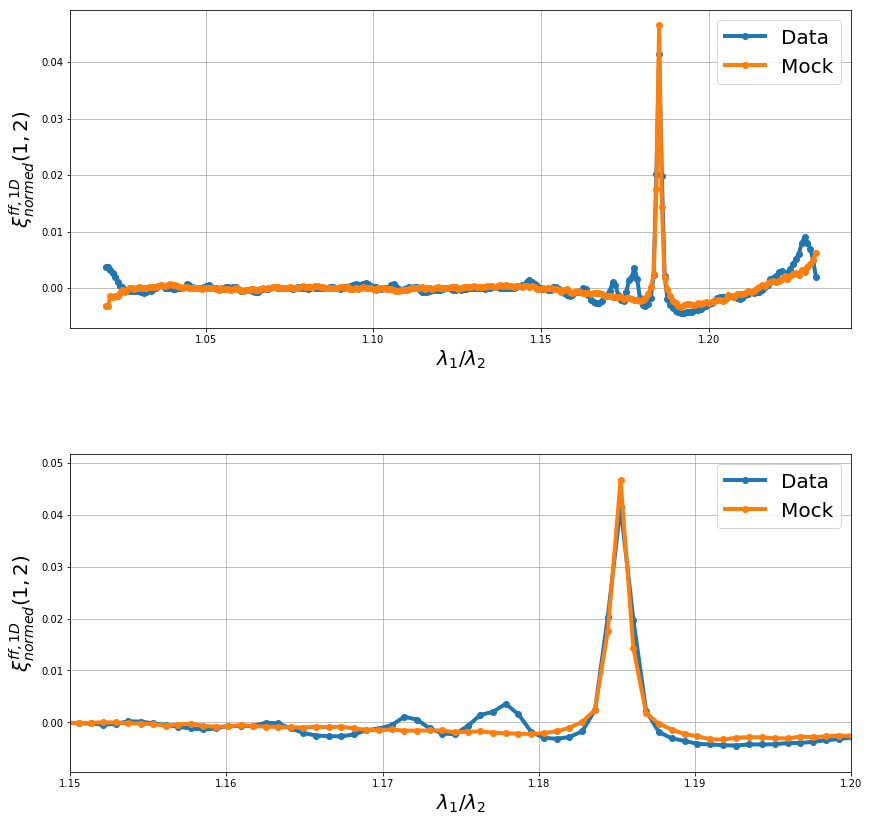

In [8]:
### The normalized correlation
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,14))

### all
for name,path in sorted(all_cf1d.items()):
    try:
        h = fitsio.FITS(path)
    except:
        print('cant find {}, skipping'.format(path))
        continue
    y = h[1]['c1d'][:] #- in the future replace '1' by '1DCOR'
    binsize = dll
    bins = sp.arange(y.size)
    x = sp.power(10,bins*binsize)
    w = h[1]['nc1d'][:]>0.
    x = x[w]
    y = y[w]
    ax1.errorbar(x,y,marker='o',linewidth=4,label=name)
    h.close()
ax1.set_xlabel(r'$\lambda_{1}/\lambda_{2}$')
ax1.set_ylabel(r'$\xi^{ff,1D}_{normed}(1,2)$')
ax1.legend()
ax1.grid()

### zoom
ymin = 1.e6
ymax = -1.e6
for name,path in sorted(all_cf1d.items()):
    try:
        h = fitsio.FITS(path)
    except:
        print("Can't find file {}, skipping".format(path))
        continue
    y = h[1]['c1d'][:] #- in the future replace '1' by '1DCOR'
    binsize = dll
    bins = sp.arange(y.size)
    x = sp.power(10,bins*binsize)
    w = h[1]['nc1d'][:]>0.
    x = x[w]
    y = y[w]
    ymin = min(ymin,y.min())
    ymax = max(ymax,y[y!=1.].max())
    ax2.errorbar(x,y,marker='o',linewidth=4,label=name)
    h.close()
ax2.set_xlim([1.15,1.20])
ax2.set_ylim([ymin-0.005,ymax+0.005])
ax2.set_xlabel(r'$\lambda_{1}/\lambda_{2}$')
ax2.set_ylabel(r'$\xi^{ff,1D}_{normed}(1,2)$')
ax2.legend()
ax2.grid()

plt.subplots_adjust(hspace=0.4)
plt.show()

# Wedge plots

The cells below display wedge plots for a given file.

Change the value of `base` to the file you wish to display.

In [31]:
base = 'cf_z_0_10-exp'
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/lybForest/lyb/'+base+'.fits',
                  'FIT':mock['picca']+'/lybForest/lyb/cf_z_0_10-exp.h5', 'NAME':base}
base = 'cf_LYA_in_LYA_LYB_in_LYB_z_0_10'
toPlot['Data'] = { 'CORR':data['picca'][:-1]+'_new/Correlations/'+base+'-exp.fits.gz',
                      'FIT':data['picca'][:-1]+'_new/Correlations/Fit/'+base+'_noMet/result.h5', 'NAME': base}

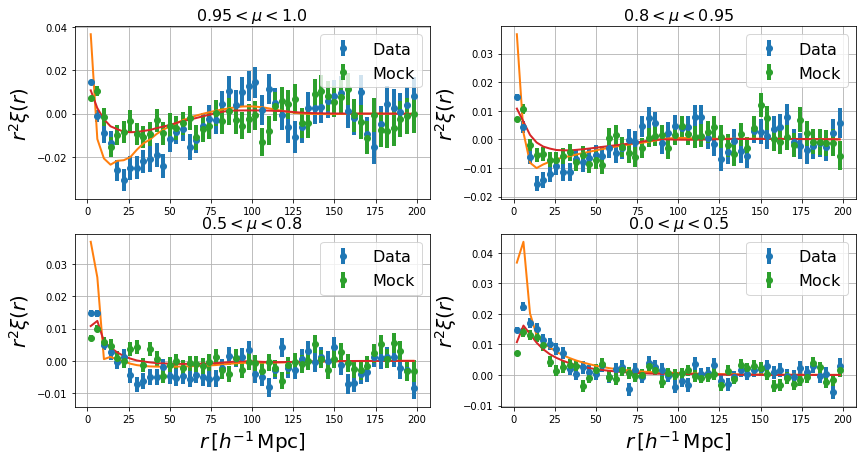

In [32]:
power = 1
mus = [1., 0.95, 0.8, 0.5, 0.]

f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    for name,paths in sorted(toPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        axs[i//2][i%2].errorbar(r,d*r**power,yerr=sp.sqrt(c.diagonal())*r**power,fmt="o",label=r'$\mathrm{'+name+'}$')
        axs[i//2][i%2].plot(r,f*r**power,linewidth=2)
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

# Slices plots

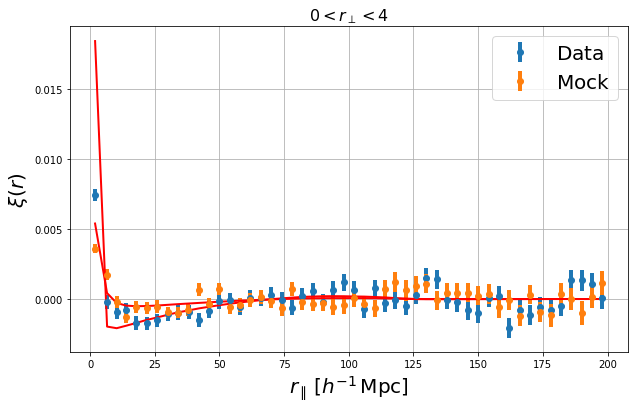

In [35]:
slices = [0]
for s in slices:
    for name,paths in sorted(toPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        ff.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        fit = fit[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(rp,fit,color='red',linewidth=2)
        ff.close()
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()